In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(1697, 35)
(1697, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FR is swinging
idxs = np.where(X_motion[:, -1] == 1)[0]
X_motion_FR_swinging = X_motion[idxs]
Y_motion_FR_swinging = Y_motion[idxs]

## Predict FR foot -> x

In [8]:
X_motion_FR_swinging[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  2.41696832e-01,
        1.28775480e-01, -3.51004333e-01,  2.41532956e-01, -1.26611500e-01,
       -3.54502552e-01, -2.75324623e-01,  1.26597516e-01, -3.55335056e-01,
       -2.75224352e-01, -1.27512049e-01, -3.52468661e-01,  3.16461945e+02,
        3.00824771e+01,  3.81847702e-01, -4.30174225e-04,  1.20267051e-03,
        1.29047892e-01,  9.91637540e-01,  7.92035070e-03,  1.74698153e-02,
       -8.05310055e-02,  3.57429791e-02, -9.50794225e-02,  2.73681594e-02,
                   nan,             nan,  1.00000000e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00])

In [9]:
Y_motion_FR_swinging[0, :]

array([0.02954405, 0.00235427, 0.02764919, 0.01213791])

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_FR_swinging[:, :3], # Previous motion command
               X_motion_FR_swinging[:, -5:-2], # Current motion command
               X_motion_FR_swinging[:, 3:5], # FL (x,y) position
               X_motion_FR_swinging[:, 6:8], # FR (x,y) position
               X_motion_FR_swinging[:, 9:11], # RL (x,y) position
               X_motion_FR_swinging[:, 12:14])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FR_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_x = LinearRegression()

# Fit the model
model_fr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9896983725514631
RMSE:  0.009770084184833832
The lowest error is:  0.0002092156860125649
The highest error is:  0.03168713434952186
The avg. error is:  0.007809985916642841


In [11]:
model_fr_relative_swinging_x.coef_

array([[-4.75679792e-02,  4.44089210e-16,  1.33226763e-15,
         2.97867469e-01, -9.99200722e-16,  2.77555756e-16,
        -1.31718635e+00,  1.44027172e+00, -7.37392382e-01,
         2.57336397e+00, -6.04126651e-01, -2.86334806e+00,
         2.19850757e+00, -1.09605516e+00]])

In [12]:
model_fr_relative_swinging_x.intercept_

array([1.29014651])

Text(0, 0.5, 'Predictions')

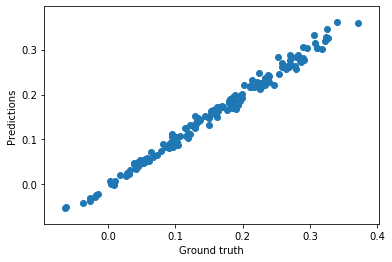

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#%store model_fr_relative_swinging_x

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
#joblib.dump(model_fr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_x.sav")

### Predict FL foot -> y

In [17]:
# Input
X = np.hstack((X_motion_FR_swinging[:, :3], # Previous motion command
               X_motion_FR_swinging[:, -5:-2], # Current motion command
               X_motion_FR_swinging[:, 3:5], # FL (x,y) position
               X_motion_FR_swinging[:, 6:8], # FR (x,y) position
               X_motion_FR_swinging[:, 9:11], # RL (x,y) position
               X_motion_FR_swinging[:, 12:14])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_y = LinearRegression()

# Fit the model
model_fr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.6533548161758638
RMSE:  0.005986368572323516
The lowest error is:  6.878622091352482e-05
The highest error is:  0.01974325879139427
The avg. error is:  0.0045639326180316195


In [18]:
model_fr_relative_swinging_y.coef_

array([[-4.62821480e-02,  3.50414142e-16,  1.52655666e-16,
         4.94955553e-02,  1.62370117e-15, -8.88178420e-16,
         2.20836762e+00, -3.95564950e-02, -3.16987161e-01,
         3.02671675e-01,  2.66564441e-01, -1.44223855e+00,
        -2.10061209e+00,  8.78044488e-01]])

In [19]:
model_fr_relative_swinging_y.intercept_

array([-0.62304166])

Text(0, 0.5, 'Predictions')

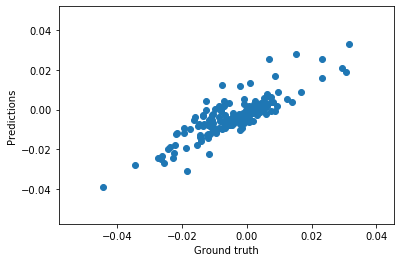

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [44]:
#%store model_fr_relative_swinging_y

In [45]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [23]:
# Save model
#joblib.dump(model_fr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_y.sav")